Code modified from: https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_02.ipynb

In [56]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy.stats as stats

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# 2.4

## Grid Search

The following graph shows the probability distribution of observing `X` successes out of `9` trials **if**  `p=0.5`

This is **not** what we are interested in, but we will use the value from the bar associated
with `6` successes and compare that value (the relative likelihood to other values) of `p`.

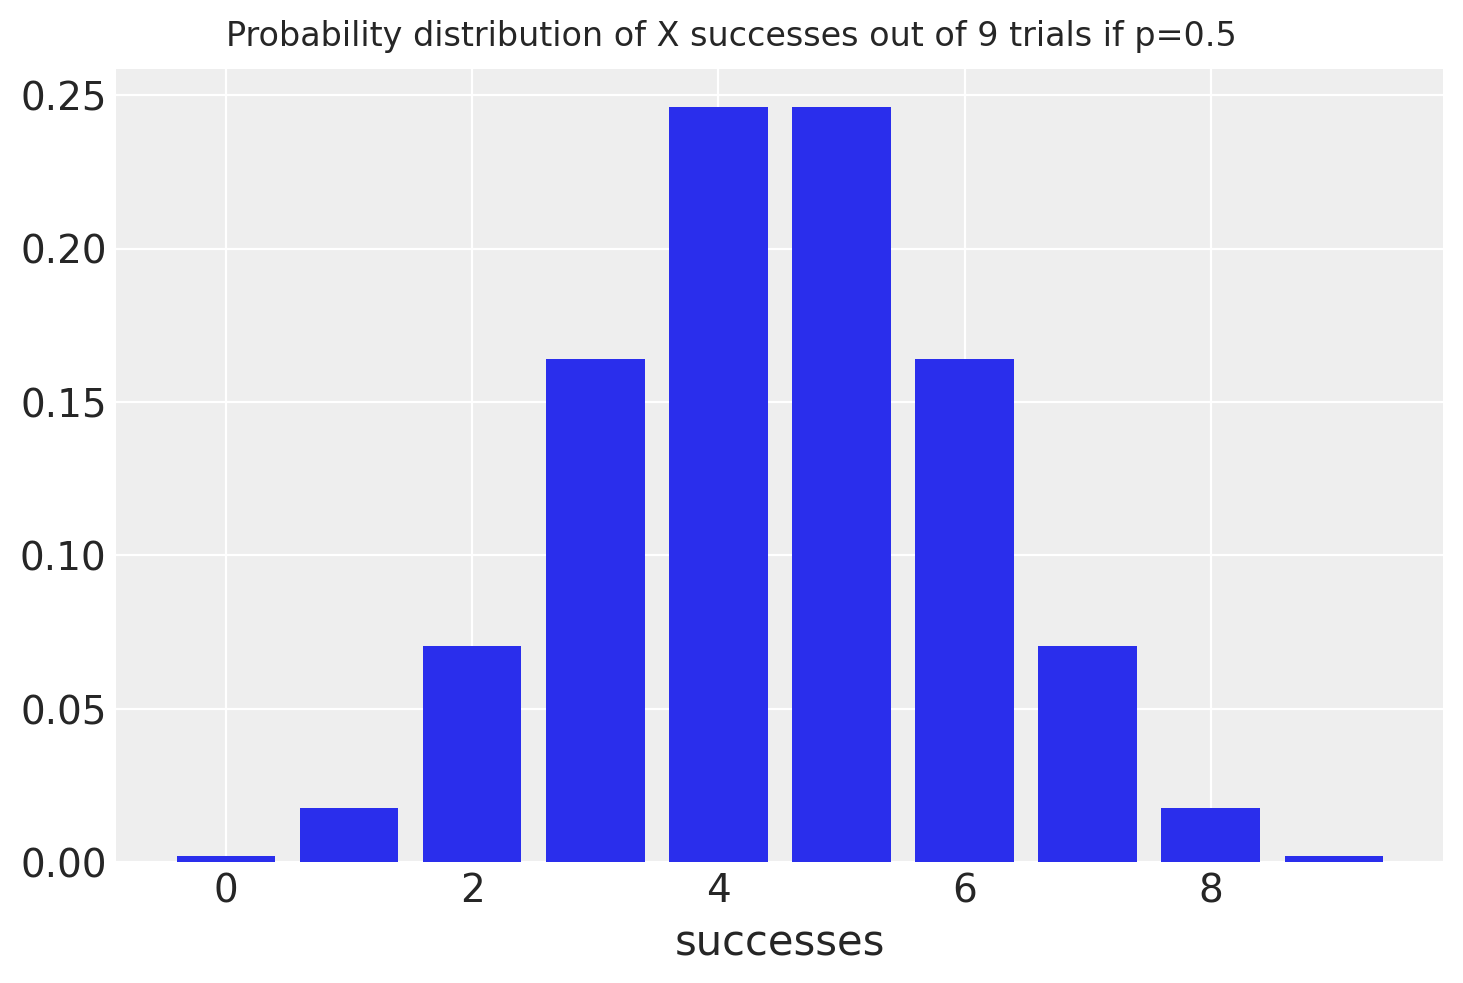

In [3]:
trials = 9
x = np.linspace(0, 9, 10)
y = stats.binom.pmf(x, n=trials, p=0.5)
plt.bar(x, y)
plt.suptitle("Probability distribution of X successes out of 9 trials if p=0.5")
plt.xlabel("successes")
plt.show()

The probability of observing six W’s in nine tosses — below a value of `p = 0.5`.

In [5]:
# pmf is 'probability mass function'
# probability of observing 6 successes out of 9 trials if p=0.5
stats.binom.pmf(6, n=9, p=0.5)

0.16406250000000003

The following graph shows the relative likelihood of observing `6` successes out of `9` trials for all values of `p`.

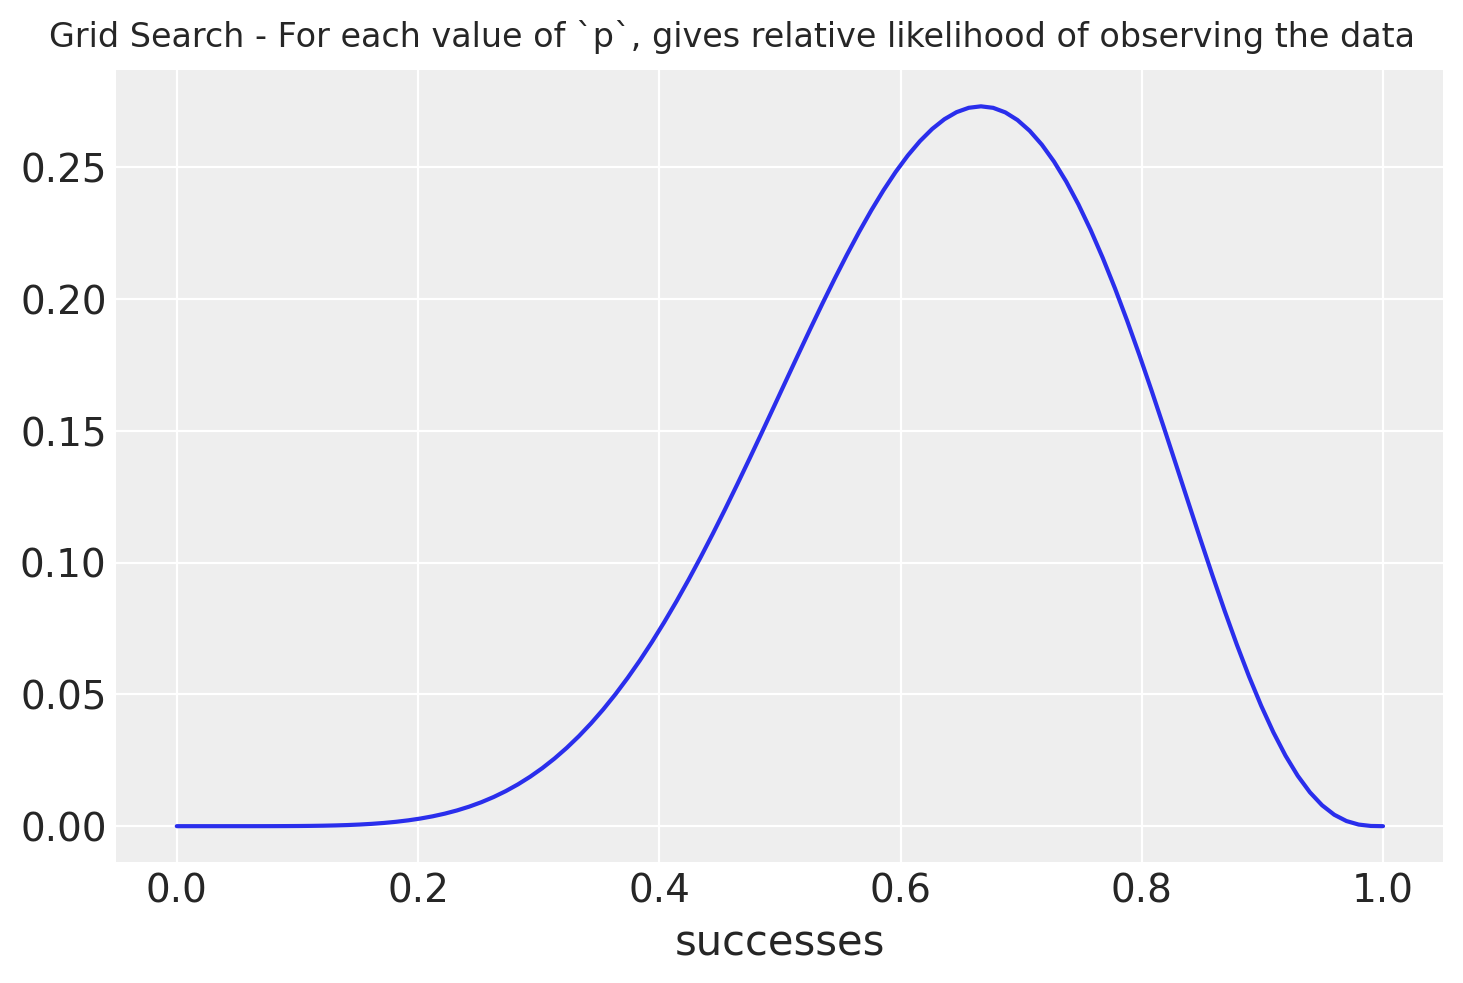

In [22]:
p = np.linspace(0, 1, 100)
y = stats.binom.pmf(6, n=9, p=p)
plt.plot(p, y)
plt.suptitle("Grid Search - For each value of `p`, gives relative likelihood of observing the data")
plt.xlabel("successes")
plt.show()

However, y does not sum to `1`, so it is not a probability distribution.

In [32]:
sum(y)

9.900000720901385

In [33]:
y = y / sum(y)
sum(y)

1.0

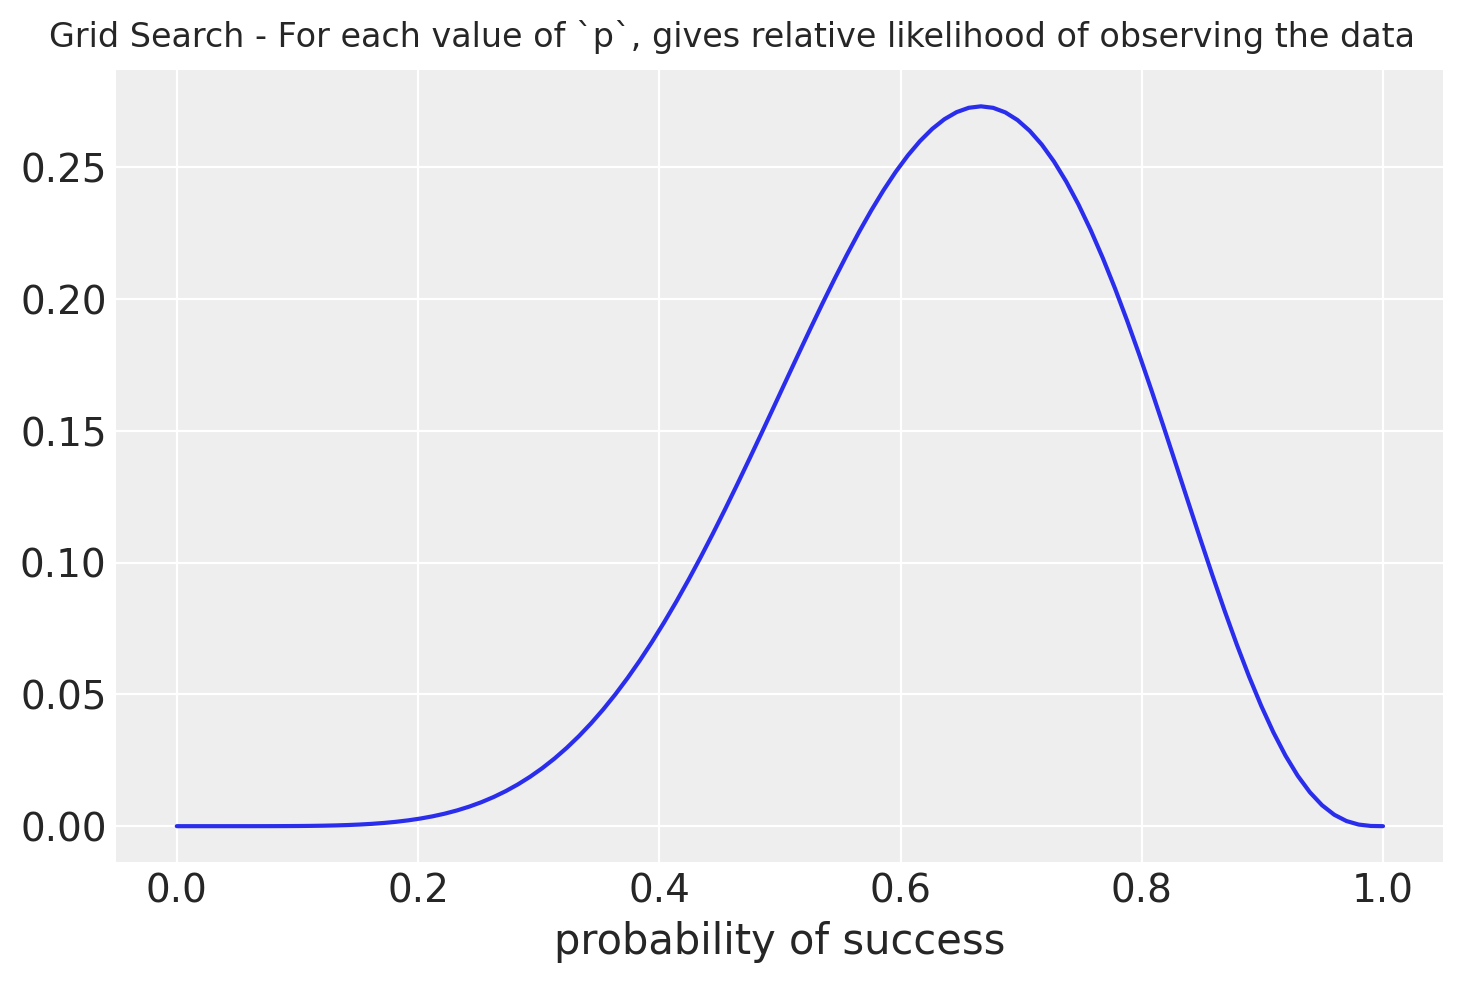

In [23]:
plt.plot(p, y)
plt.suptitle("Grid Search - For each value of `p`, gives relative likelihood of observing the data")
plt.xlabel("probability of success")
plt.show()

This is synonymous with using the `beta` function with a prior of 1 success and 1 failure.

In [17]:
successes = 6
trials = 9

# NOTE: `+1` needed to match graph above
sum(stats.beta.pdf(x=x, a=successes + 1, b=trials - successes + 1))

99.00000720901384

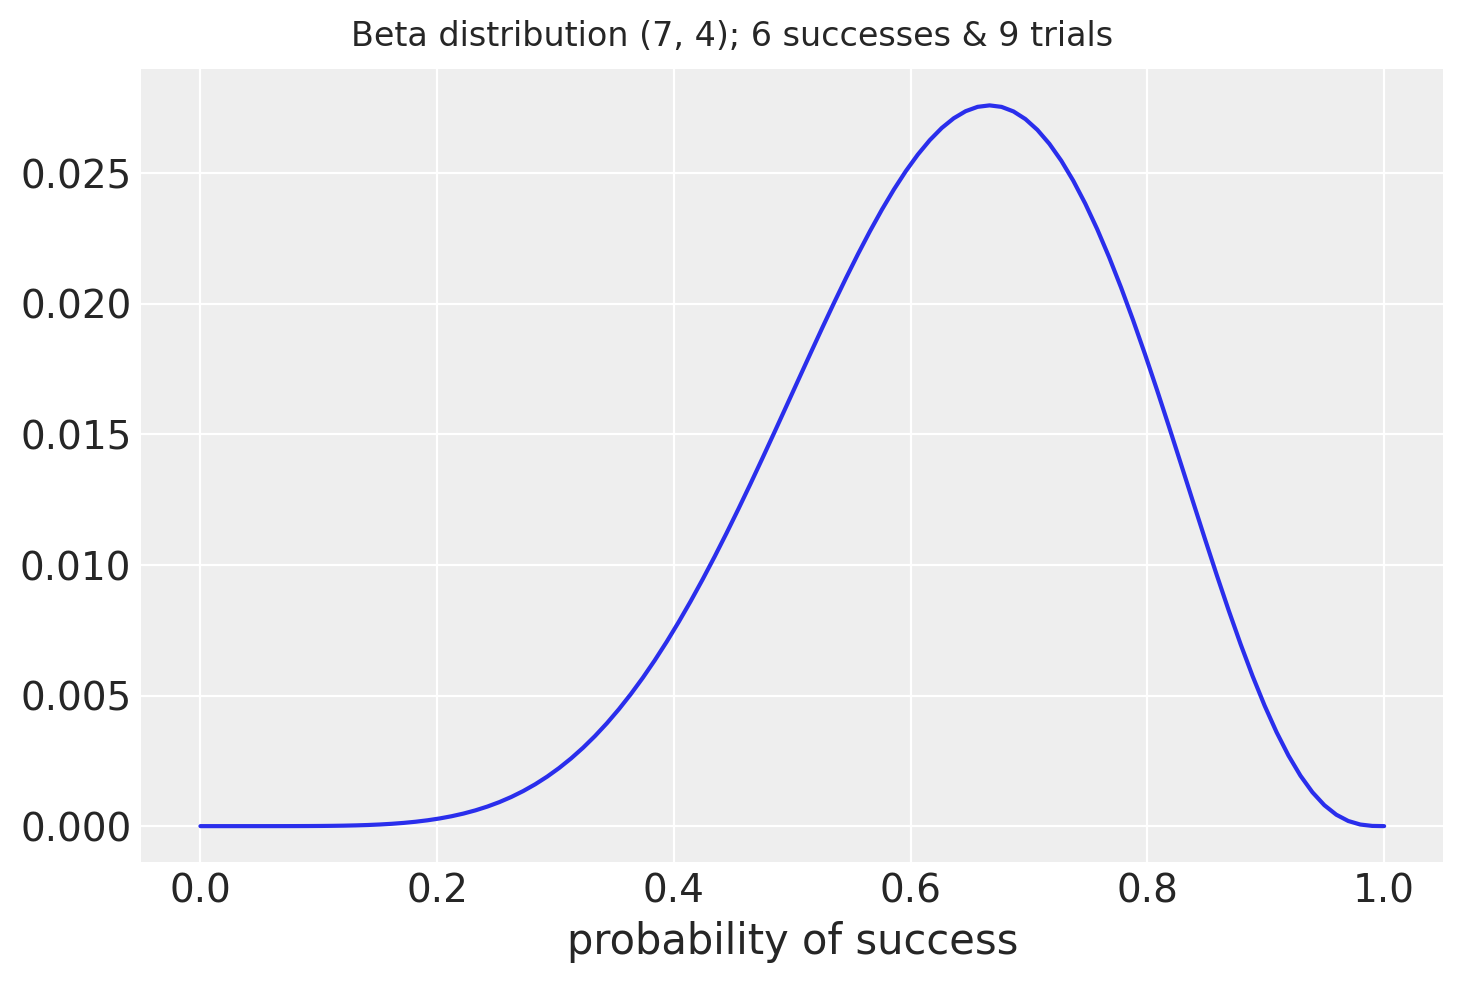

In [21]:
a = successes + 1
b = trials - successes + 1
x = np.linspace(0, 1, 100)

# NOTE: `+1` needed to match graph above
y = stats.beta.pdf(x=x, a=a, b=b)
y = y / y.sum()
plt.plot(x, y)
plt.suptitle(f"Beta distribution ({a}, {b}); {successes} successes & {trials} trials")
plt.xlabel("probability of success")
plt.show()


---

In [45]:
import pymc as pm
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


## Quadratic Approximiation

Computing the posterior using the quadratic approximation (quad).

In [25]:
data = np.repeat((0, 1), (3, 6))
data

array([0, 0, 0, 1, 1, 1, 1, 1, 1])

In [27]:
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", lower=0, upper=1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()  # Finds the local *maximum a posteriori* point given a model.

    p_value = normal_approximation.rvs_to_values[p]
    p_value.tag.transform = None
    p_value.name = p.name

    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print("Mean, Standard deviation\np {:.2}, {:.2}".format(mean_q["p"], std_q[0]))


Mean, Standard deviation
p 0.67, 0.64


In [28]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("5.5%, 94.5% \n{:.2}, {:.2}".format(pi[0], pi[1]))

5.5%, 94.5% 
-0.35, 1.7


In [31]:
with pm.Model() as normal:
    p = pm.Uniform("p", lower=0, upper=1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    idata = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


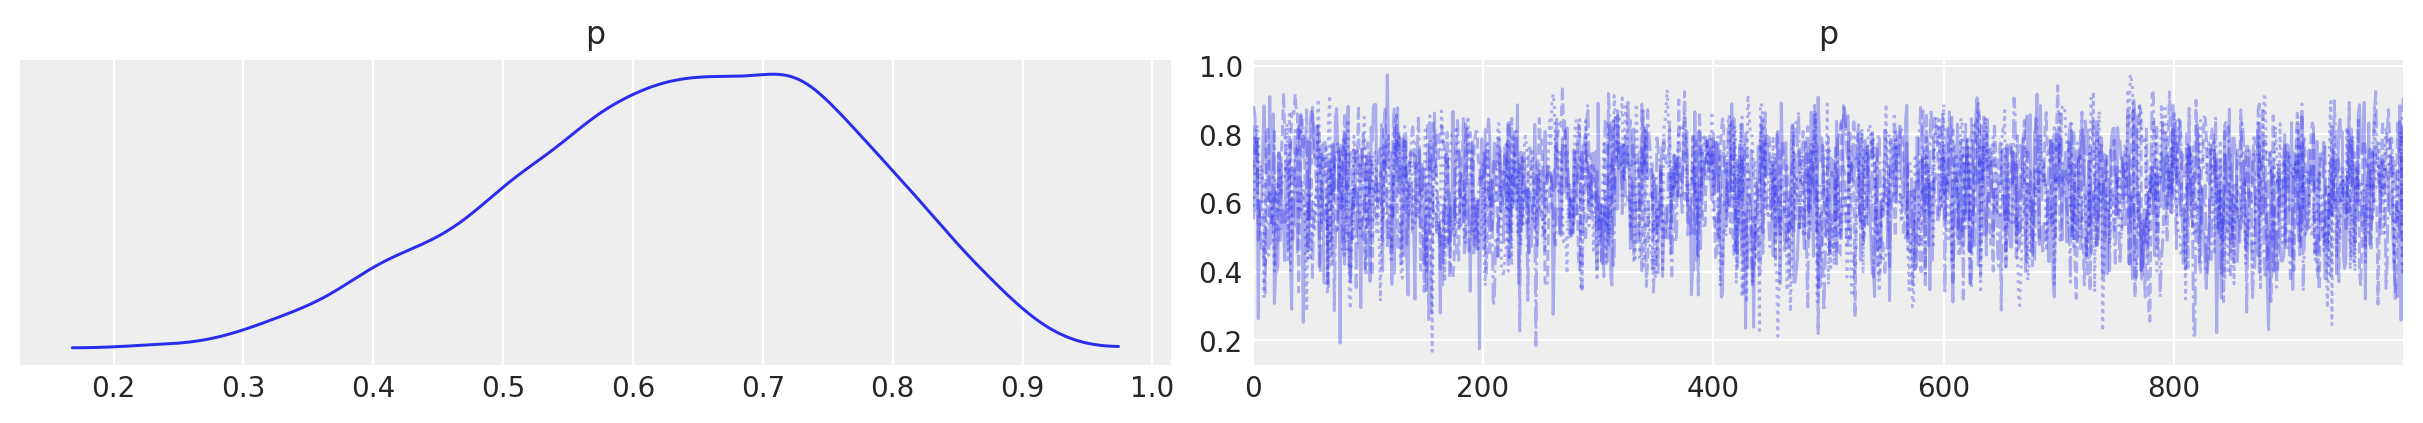

In [32]:
az.plot_trace(idata, combined=True);

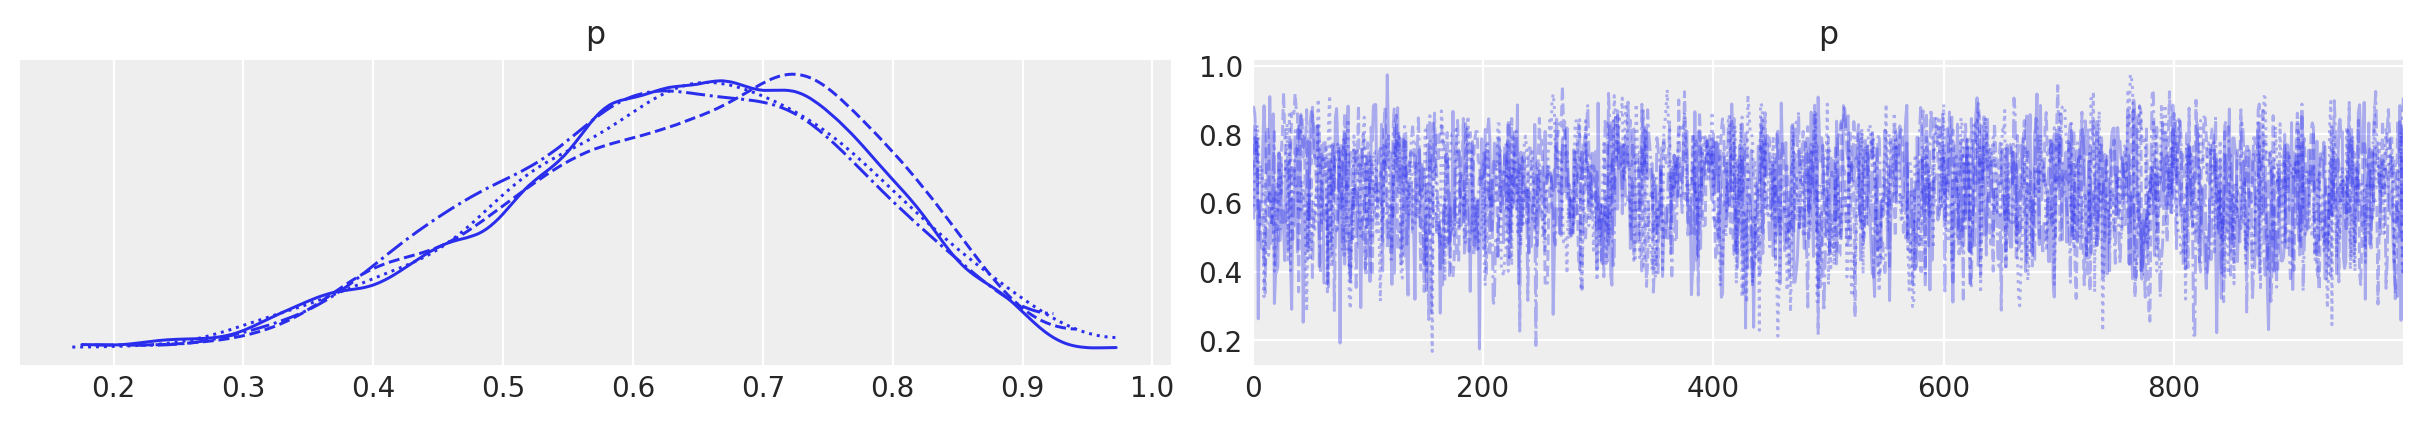

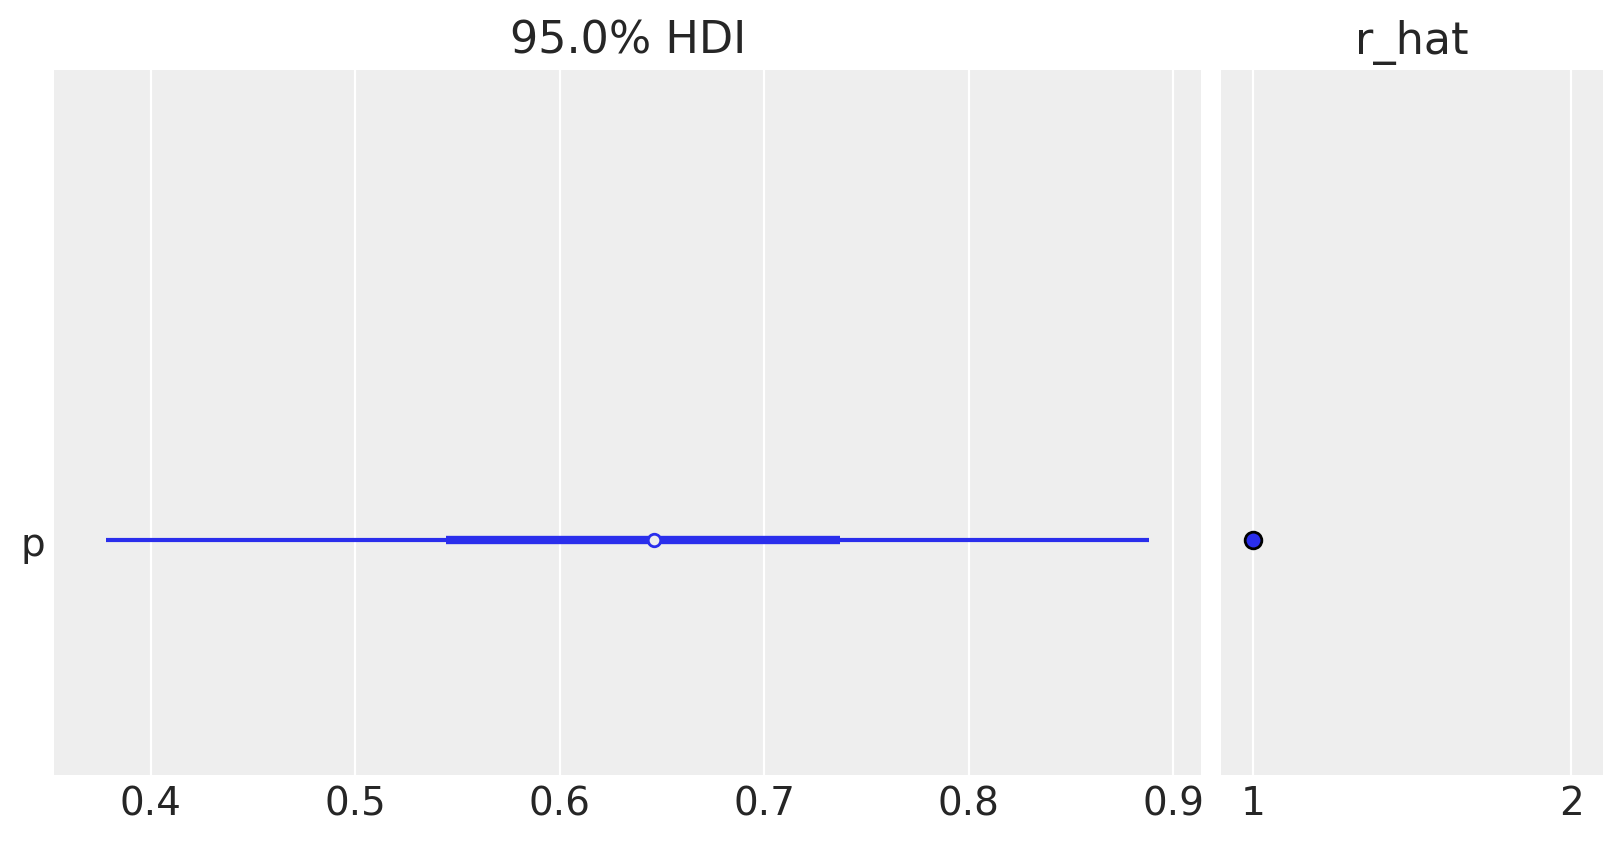

In [42]:
az.plot_forest(idata, var_names=['p'], combined=True, hdi_prob=0.95, r_hat=True);

In [54]:
az.hdi(idata, var_names=["p"], hdi_prob=0.95).to_dataframe()

,p
hdi,
lower,0.378332
higher,0.888042


In [53]:
az.hdi(idata, var_names=["p"], hdi_prob=0.50).to_dataframe()

,p
hdi,
lower,0.564070
higher,0.753894


In [40]:
samples = idata.posterior['p'].stack(draws=('chain', 'draw'))
samples.shape

(4000,)

In [51]:
float(samples.median())

0.6458866427688897